In [1]:
import argparse

from GeospatialFM.data import get_datasets
from GeospatialFM.models import *

from GeospatialFM.utils import *
from GeospatialFM.data import *
from GeospatialFM.models import *
from GeospatialFM.loss import *

from tqdm import trange, tqdm
import random
import pandas as pd
from copy import deepcopy

from sklearn.manifold import TSNE
import umap

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

import time

%load_ext autoreload
%autoreload 2

/home/haozhesi/anaconda3/envs/sat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
EUROSAT_CLS = [
    "Annual Crop",
    "Forest",
    "Herbaceous Vegetation",
    "Highway",
    "Industrial Buildings",
    "Pasture",
    "Permanent Crop",
    "Residential Buildings",
    "River",
    "Sea & Lake"
]

In [17]:
dataset = 'Euro'
modal = 'optical'
cache_path = './results/cache/'
# target_models = ['CROMA', 'SatMAE', 'mm_vit_1-2-9', 'GFM']
target_kw = ['mm_vit_1-2-9','group_c', 'euro_sat_croma', 'GFM']
target_dirs = [file for file in os.listdir(cache_path) if dataset.lower() in file.lower()]
target_dirs = [file for file in target_dirs if any([model in file for model in target_kw]) and 'old' not in file and 'gfm_GFM' not in file]
model_names = ['SatMAE', 'MM-MAE','GFM',  'CROMA', ]
vis_content = dict()
for fname, name in zip(target_dirs, model_names):
    vis_content[name] = fname
vis_content

{'SatMAE': 'euro_sat_group_c',
 'MM-MAE': 'EuroSAT_mm_lr_vit_base_patch16_224_mm_vit_1-2-9_d4_new_finetune_optical',
 'GFM': 'EuroSAT_GFM_gfm_finetune_optical',
 'CROMA': 'euro_sat_croma'}

In [18]:
# extact the model ame from the directory name, it should between the dataset name and the 'finetune'
# model_name = target_dirs[i].split(dataset+'_')[1].split('_finetune')[0]
method_feature = dict()
for name, fname in vis_content.items():
    model_name = name
    target_dir = fname
    cached_exp = os.path.join(cache_path, target_dir)
    label = dict(train=[], test=[])
    feature = dict(train=[], test=[])
    for pkls in os.listdir(cached_exp):
        assert pkls.endswith('.pkl')
        file_path = os.path.join(cached_exp, pkls)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        if 'train' in pkls:
            label['train'].append(data['label'].numpy())
            feature['train'].append(data['img_feature'].numpy())
        else:
            label['test'].append(data['label'].numpy())
            feature['test'].append(data['img_feature'].numpy())

    # label = np.concatenate(label)
    # feature = np.concatenate(feature)
    for key in label:
        label[key] = np.concatenate(label[key])
        feature[key] = np.concatenate(feature[key])
        print(feature[key].shape)
    n_ys = np.unique(label['train']).shape[0]
    scaler = StandardScaler()
    feature['train'] = scaler.fit_transform(feature['train'])
    feature['test'] = scaler.transform(feature['test'])
    
    method_feature[model_name] = dict(label=label, feature=feature, n_ys=n_ys)

(16200, 768)
(5400, 768)
(16200, 768)
(5400, 768)
(16200, 768)
(5400, 768)
(16200, 768)
(5400, 768)


In [19]:
method_feature.keys()
# method_feature['MM-MAE']

dict_keys(['SatMAE', 'MM-MAE', 'GFM', 'CROMA'])

In [20]:
# scaler = StandardScaler()
# feature['train'] = scaler.fit_transform(feature['train'])
# feature['test'] = scaler.transform(feature['test'])

In [21]:
# tsne = TSNE(n_components=2, random_state=42, perplexity=30)  # perplexity is a key parameter
# X_embedded = tsne.fit_transform(feature['test'])

In [22]:
# plt.figure(figsize=(8, 6))
# for i in range(n_ys):
#     plt.scatter(X_embedded[label == i, 0], X_embedded[label == i, 1], label=f'Class {i}', alpha=0.5)
# plt.legend()
# plt.show()

In [38]:
for key in method_feature:
    knn = KNeighborsClassifier(n_neighbors=20, metric='cosine')
    # knn = KNeighborsClassifier(n_neighbors=20) 
    knn.fit(method_feature[key]['feature']['train'], method_feature[key]['label']['train'])
    y_pred = knn.predict(method_feature[key]['feature']['test'])
    acc = accuracy_score(method_feature[key]['label']['test'], y_pred)
    print(f'{key} accuracy: {acc*100:.2f}%')
    method_feature[key]['knn_acc'] = acc
# knn.fit(feature['train'], label['train'])

SatMAE accuracy: 84.46%
MM-MAE accuracy: 91.65%
GFM accuracy: 79.26%
CROMA accuracy: 89.59%


In [25]:
for key in tqdm(method_feature):
    reducer = umap.UMAP(n_neighbors=20, min_dist=0.0)  # n_neighbors and min_dist are key parameters
    start_time = time.time()
    X_embedded = reducer.fit_transform(method_feature[key]['feature']['test'])
    end_time = time.time()
    print(f'{key} UMAP time: {end_time - start_time}')
    method_feature[key]['umap'] = X_embedded
# reducer = umap.UMAP(n_neighbors=20, min_dist=0.0)  # n_neighbors and min_dist are key parameters
# X_embedded = reducer.fit_transform(feature['test'])

 25%|██▌       | 1/4 [00:24<01:13, 24.60s/it]

SatMAE UMAP time: 24.596071481704712


 50%|█████     | 2/4 [00:46<00:46, 23.13s/it]

MM-MAE UMAP time: 22.088042736053467


 75%|███████▌  | 3/4 [01:03<00:20, 20.43s/it]

GFM UMAP time: 17.213237047195435


100%|██████████| 4/4 [01:23<00:00, 20.89s/it]

CROMA UMAP time: 19.65175700187683


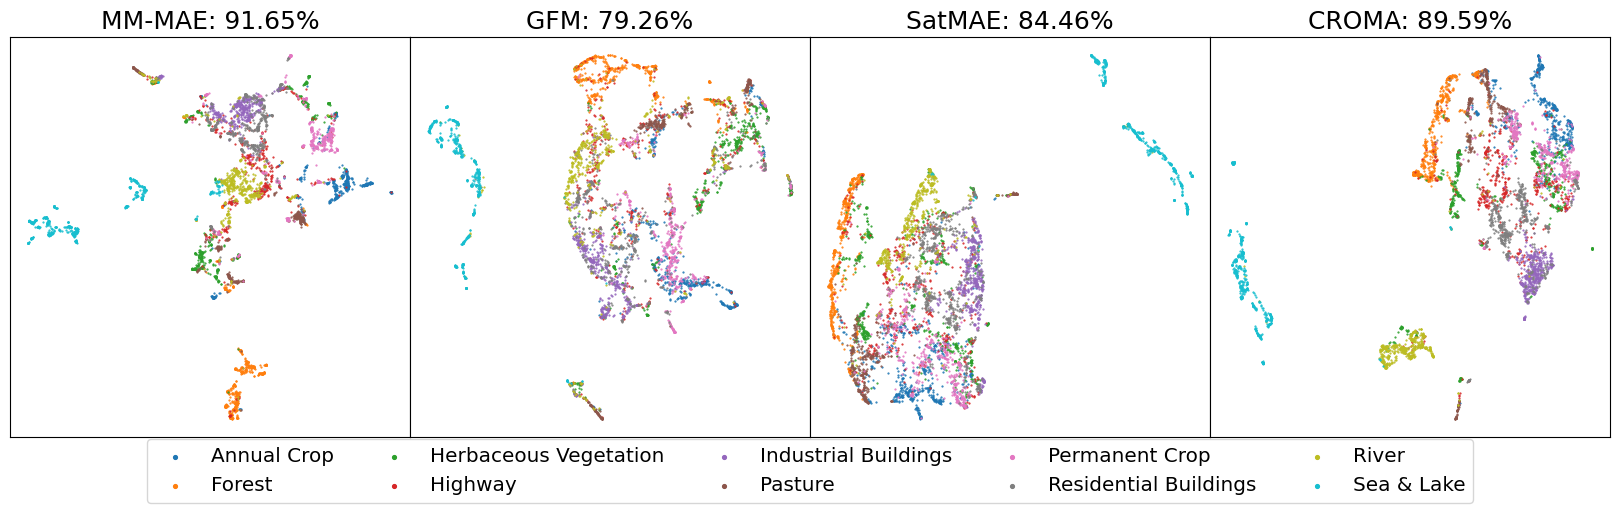

In [46]:
# for every model, plot the UMAP embedding
vis_order = ['MM-MAE', 'GFM', 'SatMAE', 'CROMA']
n_models = len(method_feature)
fig, ax = plt.subplots(1, n_models, figsize=(4 * n_models, 4))
for i, key in enumerate(vis_order):
    X_embedded = method_feature[key]['umap']
    for j in range(method_feature[key]['n_ys']):
        ax[i].scatter(X_embedded[method_feature[key]['label']['test'] == j, 0], X_embedded[method_feature[key]['label']['test'] == j, 1], label=f'Class {j}', marker='o', s=0.3,)
    ax[i].set_title(f"{key}: {method_feature[key]['knn_acc']*100:.2f}%", fontsize=18)
    # ax[i].legend()
    # ax[i].axis('off')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    # ax[i].set_aspect('')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
# show legend at the bottom center of the complete image
# fig.legend(loc='lower center', ncol=method_feature[key]['n_ys']//2, fontsize='small', bbox_to_anchor=(0.5, -0.12))
# only plot one set of legend without the showing the actuall bbox
fig.legend(EUROSAT_CLS, loc='lower center', ncol=method_feature[key]['n_ys']//2, fontsize='x-large', bbox_to_anchor=(0.5, -0.19), markerscale=5, scatterpoints=1)
# plt.savefig(f'umap_{dataset}_{modal}.png', dpi=300, bbox_inches='tight')

In [39]:
# # Plot
# plt.figure(figsize=(8, 6))
# for i in range(n_ys):
#     plt.scatter(X_embedded[label['test'] == i, 0], X_embedded[label['test'] == i, 1], label=f'Class {i}', marker='.', s=1)
# # set the title
# plt.title(f'UMAP visualization of {dataset} dataset using {model_name} model with {modal} data')
# # put the legend at the botton of the figure
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=5)
# plt.show()

In [40]:
# y_pred = knn.predict(feature['test'])

In [41]:
# accuracy = accuracy_score(label['test'], y_pred)
# print(f"Accuracy: {accuracy*100:.2f}%")

In [42]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(feature['test'])

In [43]:
kmeans = KMeans(n_clusters=n_ys, random_state=42, n_init=10)

In [44]:
kmeans.fit(X_scaled)

# Make predictions
y_kmeans = kmeans.predict(X_scaled)

In [45]:
conf_matrix = confusion_matrix(label['test'], y_kmeans)
row_ind, col_ind = linear_sum_assignment(-conf_matrix)

In [46]:
conf_matrix, row_ind, col_ind

(array([[209,   0,  29,   0,   0,   0, 367,   2,   6,   0],
        [266,   0,   0,   1,   0,   0,   0, 336,   2,   0],
        [ 94,   0,  55,  17,  17,   2, 198, 186,  41,  18],
        [ 88,   0, 193,  28,   1,   0,  63,  74,  26,  26],
        [  1,   0,  60,   3,   0,   0,  13,   0,  50, 380],
        [352,   0,   7,   3,   0,   0,   2,  45,   0,   0],
        [151,   0,  32,   1,   0,   0, 285,   3,   9,   0],
        [ 17,   0, 354,   1,   0,   0,  67,   9,  68,  67],
        [  7,   2,   8, 285, 198,   1,   2,   3,   4,   1],
        [  0, 343,   2,   1,   3, 213,   0,   1,   1,   0]]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([6, 7, 4, 8, 9, 0, 5, 2, 3, 1]))

In [47]:
mapped_cluster_labels = np.zeros_like(y_kmeans)
for i, j in enumerate(col_ind):
    mapped_cluster_labels[y_kmeans == j] = i

# Calculate accuracy
accuracy = accuracy_score(label['test'], mapped_cluster_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 45.56%
